In [ ]:
#!pip install mujoco

# Set up GPU rendering.
#from google.colab import files
import distutils.util
import os
import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# # Configure MuJoCo to use the EGL rendering backend (requires GPU)
# print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
print('Installing mediapy:')
#!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
#!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [ ]:
print('Getting MuJoCo humanoid XML description from GitHub:')
#!git clone https://github.com/google-deepmind/mujoco
with open('humanoid.xml', 'r') as f:
  xml = f.read()

Getting MuJoCo humanoid XML description from GitHub:


In [ ]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

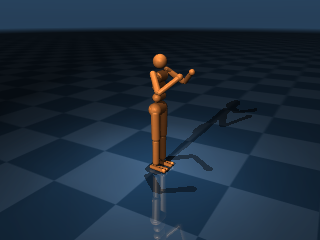

In [ ]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

""

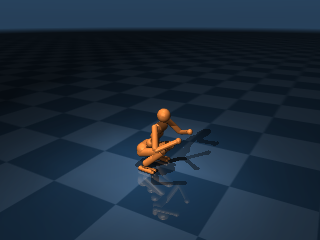

""

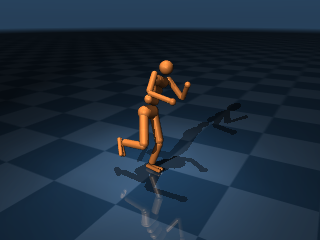

""

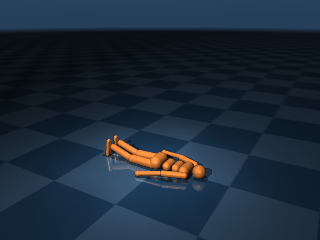

""

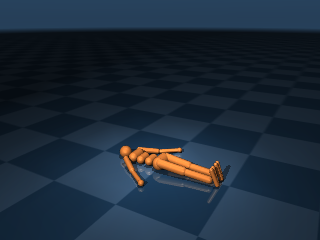

In [ ]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [ ]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

In [ ]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Set control vector.
  data.ctrl = np.random.randn(model.nu)

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [ ]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

[ -0.     -0.    275.879 -33.186   4.995  -6.688  -4.305   3.693 -15.451 -10.906   0.412  -1.613
  -9.793  -2.312  -0.366  -5.913  -0.417  -1.914   5.759   2.665  -0.202  -5.755   0.994   1.141
  -1.987   3.821   1.151]


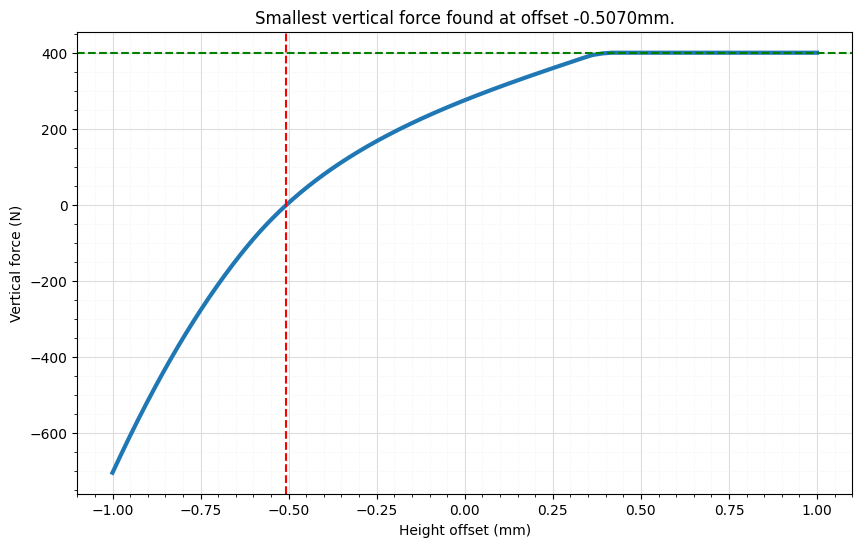

In [ ]:
height_offsets = np.linspace(-0.001, 0.001, 2001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 1)
  mujoco.mj_forward(model, data)
  data.qacc = 0
  # Offset the height by `offset`.
  data.qpos[2] += offset
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

# Plot the relationship.
plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
# Red vertical line at offset corresponding to smallest vertical force.
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
# Green horizontal line at the humanoid's weight.
weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
plt.axhline(y=weight, color='green', linestyle='--')
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

In [ ]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

desired forces: [ -0.     -0.     -0.191  -3.447   0.222  -0.817   2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [ ]:
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

control setpoint: [ 0.065  0.366 -0.466 -0.273  0.01  -0.013 -0.122 -0.116 -0.018 -0.594 -0.054  0.102  0.326  0.667
 -0.006 -0.288  0.05   0.029 -0.099  0.191  0.029]


In [ ]:
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [  0.      0.      0.      0.      0.      0.      2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [ ]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [ ]:
nu = model.nu  # Alias for the number of actuators.
R = np.eye(nu)

In [ ]:
nv = model.nv  # Shortcut for the number of DoFs.

# Get the Jacobian for the root body (torso) CoM.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
mujoco.mj_forward(model, data)
jac_com = np.zeros((3, nv))
mujoco.mj_jacSubtreeCom(model, data, jac_com, model.body('torso').id)

# Get the Jacobian for the left foot.
jac_foot = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_foot, None, model.body('foot_left').id)

jac_diff = jac_com - jac_foot
Qbalance = jac_diff.T @ jac_diff

In [ ]:
# Get all joint names.
joint_names = [model.joint(i).name for i in range(model.njnt)]

# Get indices into relevant sets of joints.
root_dofs = range(6)
body_dofs = range(6, nv)
abdomen_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'abdomen' in name
    and not 'z' in name
]
left_leg_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'left' in name
    and ('hip' in name or 'knee' in name or 'ankle' in name)
    and not 'z' in name
]
balance_dofs = abdomen_dofs + left_leg_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)

In [ ]:
# Cost coefficients.
BALANCE_COST        = 1000  # Balancing.
BALANCE_JOINT_COST  = 3     # Joints required for balancing.
OTHER_JOINT_COST    = .3    # Other joints.

# Construct the Qjoint matrix.
Qjoint = np.eye(nv)
Qjoint[root_dofs, root_dofs] *= 0  # Don't penalize free joint directly.
Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST

# Construct the Q matrix for position DoFs.
Qpos = BALANCE_COST * Qbalance + Qjoint

# No explicit penalty for velocities.
Q = np.block([[Qpos, np.zeros((nv, nv))],
              [np.zeros((nv, 2*nv))]])

In [ ]:
# Set the initial state and control.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0
data.qpos = qpos0

# Allocate the A and B matrices, compute them.
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
epsilon = 1e-6
flg_centered = True
mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, None, None)

In [ ]:
# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Compute the feedback gain matrix K.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

In [ ]:
# Parameters.
DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [ ]:
# Parameters.
DURATION = 12         # seconds
FRAMERATE = 60        # Hz
TOTAL_ROTATION = 15   # degrees
CTRL_RATE = 0.8       # seconds
BALANCE_STD = 0.01    # actuator units
OTHER_STD = 0.08      # actuator units

# Make new camera, set distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2.3

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# Set the scale of visualized contact forces to 1cm/N.
model.vis.map.force = 0.01

# Define smooth orbiting function.
def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time*2*np.pi)
def azimuth(time: float) -> float:
  return 100 + unit_smooth(data.time/DURATION) * TOTAL_ROTATION

# Precompute some noise.
np.random.seed(1)
nsteps = int(np.ceil(DURATION/model.opt.timestep))
perturb = np.random.randn(nsteps, nu)

# Scaling vector with different STD for "balance" and "other"
CTRL_STD = np.empty(nu)
for i in range(nu):
  joint = model.actuator(i).trnid[0]
  dof = model.joint(joint).dofadr[0]
  CTRL_STD[i] = BALANCE_STD if dof in balance_dofs else OTHER_STD

# Smooth the noise.
width = int(nsteps * CTRL_RATE/DURATION)
kernel = np.exp(-0.5*np.linspace(-3, 3, width)**2)
kernel /= np.linalg.norm(kernel)
for i in range(nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode='same')

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# New renderer instance with higher resolution.
renderer = mujoco.Renderer(model, width=1280, height=720)

frames = []
step = 0
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Add perturbation, increment step.
  data.ctrl += CTRL_STD * perturb[step]
  step += 1

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    camera.azimuth = azimuth(data.time)
    renderer.update_scene(data, camera, scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)